In [1]:
import copy
import os
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from torchview import draw_graph
from torchvision import datasets, transforms
from torchvision.models import ResNet34_Weights, resnet34
from torchvision.utils import make_grid

train: 45000 images across 10 classes
val: 5000 images across 10 classes
test: 10000 images across 10 classes
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Loaded batch shapes: torch.Size([32, 3, 224, 224]) torch.Size([32])
Loaded batch shapes: torch.Size([32, 3, 224, 224]) torch.Size([32])


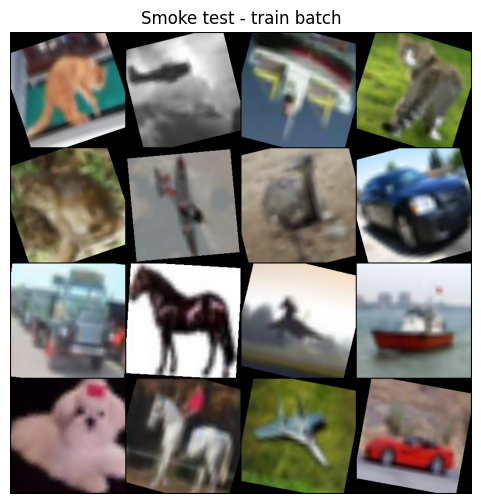

In [2]:
# point to the local CIFAR-10 batch folder present in the repo
DATA_ROOT = Path("cifar-10-batches-py")
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 1

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def create_dataloaders(data_root: Path,
                       batch_size: int = BATCH_SIZE,
                       img_size: int = IMG_SIZE,
                       num_workers: int = NUM_WORKERS,
                       val_split: float = 0.1):
    """Create dataloaders for CIFAR-10 (raw batch files) or fallback to ImageFolder layout."""
    data_root = Path(data_root)
    if not data_root.exists():
        raise FileNotFoundError(f"Dataset root not found: {data_root.resolve()}")

    # transforms resize CIFAR images to IMG_SIZE so pretrained ResNet34 can be used
    train_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomAffine(degrees=20, scale=(0.9, 1.1)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

    eval_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

    # detect CIFAR-10 batch folder (this repo contains cifar-10-batches-py)
    cifar_folder = None
    if (data_root / "cifar-10-batches-py").exists():
        # torchvision expects the parent folder to store CIFAR files
        cifar_folder = str(data_root)
    elif data_root.name == "cifar-10-batches-py" and data_root.exists():
        cifar_folder = str(data_root.parent)
    elif (data_root / "data_batch_1").exists() or (data_root / "test_batch").exists():
        cifar_folder = str(data_root)

    datasets_map = {}

    if cifar_folder is not None:
        # load CIFAR-10 using torchvision (no download; expects batch files present)
        full_train = datasets.CIFAR10(cifar_folder, train=True, transform=train_transforms, download=False)
        test_ds = datasets.CIFAR10(cifar_folder, train=False, transform=eval_transforms, download=False)

        # create validation split from training set
        val_size = int(len(full_train) * val_split)
        train_size = len(full_train) - val_size
        if val_size <= 0:
            train_ds = full_train
            val_ds = None
        else:
            train_ds, val_ds = torch.utils.data.random_split(full_train, [train_size, val_size],
                                                       generator=torch.Generator().manual_seed(42))

        datasets_map["train"] = train_ds
        if val_ds is not None:
            datasets_map["val"] = val_ds
        datasets_map["test"] = test_ds

        classes = full_train.classes
    else:
        # fallback: expect ImageFolder layout under data_root/train and data_root/val
        train_folder = data_root / "train"
        val_folder = data_root / "val"
        if not train_folder.exists() or not val_folder.exists():
            raise FileNotFoundError("Expected either CIFAR-10 batch files (cifar-10-batches-py) or an ImageFolder layout with 'train' and 'val' directories.")
        datasets_map = {
            "train": datasets.ImageFolder(root=train_folder, transform=train_transforms),
            "val": datasets.ImageFolder(root=val_folder, transform=eval_transforms),
        }
        if (data_root / "test").exists():
            datasets_map["test"] = datasets.ImageFolder(root=data_root / "test", transform=eval_transforms)
        classes = datasets_map["train"].classes

    dataloaders = {
        split: DataLoader(ds,
                          batch_size=batch_size,
                          shuffle=(split == "train"),
                          num_workers=num_workers,
                          pin_memory=torch.cuda.is_available())
        for split, ds in datasets_map.items()
    }

    return dataloaders, classes


# create dataloaders (will detect local cifar-10-batches-py if present)
dataloaders, class_names = create_dataloaders(DATA_ROOT)

for split, loader in dataloaders.items():
    try:
        n = len(loader.dataset)
    except Exception:
        # Subset may not implement len reliably in some edge cases; fall back to 0
        n = getattr(loader.dataset, "__len__", lambda: 0)()
    print(f"{split}: {n} images across {len(class_names)} classes")

print(f"Classes: {class_names}")

# Defaults for training (used later in notebook)
EPOCHS = globals().get('EPOCHS', 5)
LEARNING_RATE = globals().get('LEARNING_RATE', 1e-3)

# Quick smoke-test: load one batch and display a grid
try:
    batch = next(iter(dataloaders['train']))
    images, labels = batch
    print('Loaded batch shapes:', images.shape, labels.shape)

    # unnormalize and show grid (may be redundant with later visualizer)
    imgs = images[:16].detach().cpu()
    mean = torch.tensor(IMAGENET_MEAN).view(-1, 1, 1)
    std = torch.tensor(IMAGENET_STD).view(-1, 1, 1)
    imgs = imgs * std + mean
    grid = make_grid(imgs, nrow=4, padding=2)
    np_img = grid.permute(1, 2, 0).numpy().clip(0, 1)
    plt.figure(figsize=(6, 6))
    plt.imshow(np_img)
    plt.axis('off')
    plt.title('Smoke test - train batch')
    plt.show()
except Exception as e:
    print('Smoke test failed:', e)

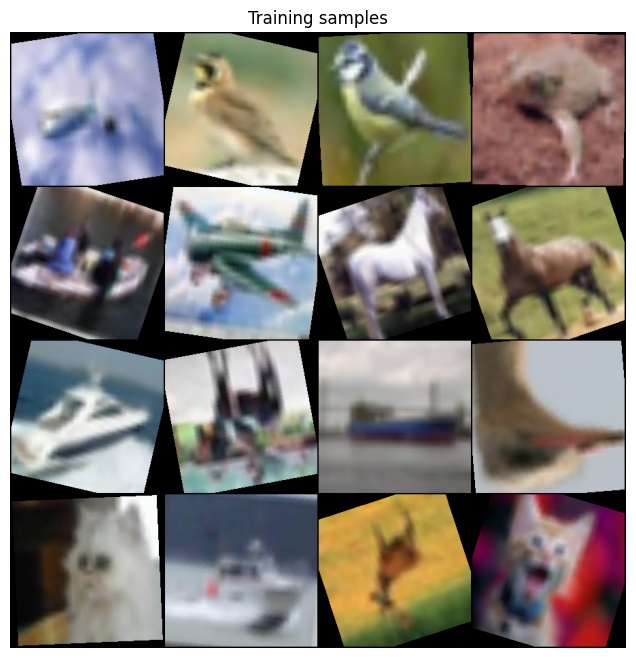

In [3]:
def visualize_batch(dataloader, n_images: int = 16, title: Optional[str] = None):
    """Display a grid of images from a dataloader batch."""
    if n_images < 1:
        raise ValueError("n_images must be at least 1")

    images, labels = next(iter(dataloader))
    n_images = min(n_images, images.size(0))
    images = images[:n_images].detach().cpu()

    mean = torch.tensor(IMAGENET_MEAN).view(-1, 1, 1)
    std = torch.tensor(IMAGENET_STD).view(-1, 1, 1)
    images = images * std + mean

    grid = make_grid(images, nrow=int(n_images**0.5) or 1, padding=2)
    np_img = grid.permute(1, 2, 0).numpy().clip(0, 1)

    plt.figure(figsize=(8, 8))
    plt.imshow(np_img)
    plt.axis("off")
    plt.title(title or "Sample batch")
    plt.show()


visualize_batch(dataloaders["train"], title="Training samples")

In [4]:
def get_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


def build_feature_extractor(num_classes: int) -> nn.Module:
    """Load a pretrained ResNet-50 and expose a trainable classifier head."""
    weights = ResNet34_Weights.IMAGENET1K_V1
    model = resnet34(weights=weights)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


def train_one_epoch(model: nn.Module,
                    dataloader: DataLoader,
                    criterion: nn.Module,
                    optimizer: torch.optim.Optimizer,
                    device: torch.device,
                    epoch: int,
                    total_epochs: int) -> tuple[float, float]:
    model.train()
    running_loss = 0.0
    running_corrects = 0
    samples = 0

    for inputs, labels in tqdm(dataloader,
                               desc=f"Train [{epoch + 1}/{total_epochs}]",
                               leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += outputs.argmax(dim=1).eq(labels).sum().item()
        samples += inputs.size(0)

    return running_loss / samples, running_corrects / samples


def evaluate(model: nn.Module,
             dataloader: Optional[DataLoader],
             criterion: nn.Module,
             device: torch.device,
             split: str,
             epoch: Optional[int] = None,
             total_epochs: Optional[int] = None) -> tuple[float, float]:
    if dataloader is None:
        return float("nan"), float("nan")

    model.eval()
    running_loss = 0.0
    running_corrects = 0
    samples = 0

    if epoch is not None and total_epochs is not None:
        desc = f"{split.capitalize()} [{epoch + 1}/{total_epochs}]"
    else:
        desc = split.capitalize()

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=desc, leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += outputs.argmax(dim=1).eq(labels).sum().item()
            samples += inputs.size(0)

    if samples == 0:
        return float("nan"), float("nan")

    return running_loss / samples, running_corrects / samples


def train_feature_extractor(dataloaders: dict,
                            num_classes: int,
                            epochs: int = EPOCHS,
                            lr: float = LEARNING_RATE) -> tuple[nn.Module, dict[str, list[float]]]:
    train_loader = dataloaders.get("train")
    val_loader = dataloaders.get("val")
    if train_loader is None or val_loader is None:
        raise ValueError("Both 'train' and 'val' splits are required for training.")

    device = get_device()
    print(f"Using device: {device}")

    model = build_feature_extractor(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = StepLR(optimizer, step_size=max(epochs // 2, 1), gamma=0.1) if epochs > 1 else None

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_weights = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, epochs)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device, split="val", epoch=epoch, total_epochs=epochs)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if scheduler is not None:
            scheduler.step()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())

        print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    model.load_state_dict(best_weights)
    print(f"Best validation accuracy: {best_val_acc:.4f}")

    test_loader = dataloaders.get("test")
    if test_loader is not None:
        test_loss, test_acc = evaluate(model, test_loader, criterion, device, split="test")
        print(f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")

    return model, history


feature_model, training_history = train_feature_extractor(dataloaders,
                                                          num_classes=len(class_names),
                                                          epochs=EPOCHS,
                                                          lr=LEARNING_RATE)

Using device: cuda


Train [1/5]:   0%|          | 0/1407 [00:00<?, ?it/s]

Val [1/5]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 1.1331 Acc: 0.6146 | Val Loss: 0.9109 Acc: 0.6876


Train [2/5]:   0%|          | 0/1407 [00:00<?, ?it/s]

Val [2/5]:   0%|          | 0/157 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       <function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can o

Epoch 2/5 | Train Loss: 0.9486 Acc: 0.6703 | Val Loss: 0.8974 Acc: 0.6908


Train [3/5]:   0%|          | 0/1407 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can

Val [3/5]:   0%|          | 0/157 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'ca

Epoch 3/5 | Train Loss: 0.8969 Acc: 0.6921 | Val Loss: 0.8448 Acc: 0.7082


Train [4/5]:   0%|          | 0/1407 [00:00<?, ?it/s]

Val [4/5]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.8832 Acc: 0.6942 | Val Loss: 0.8472 Acc: 0.7008


Train [5/5]:   0%|          | 0/1407 [00:00<?, ?it/s]

Val [5/5]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.8797 Acc: 0.6974 | Val Loss: 0.8480 Acc: 0.7084
Best validation accuracy: 0.7084


Test:   0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.5229 Acc: 0.8289


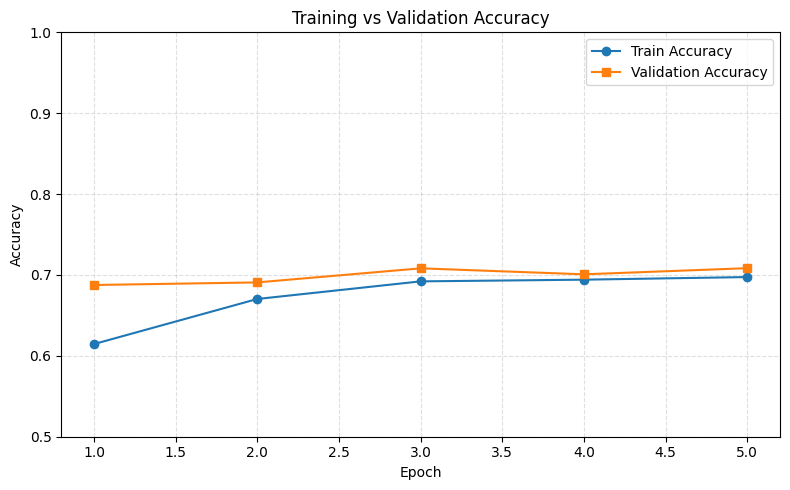

In [9]:
def plot_accuracy(history: dict[str, list[float]]):
    """Plot training and validation accuracy history."""
    epochs = range(1, len(history.get("train_acc", [])) + 1)
    if not epochs:
        raise ValueError("History is empty; run training before plotting.")

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker="o")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker="s")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.ylim(0.50, 1.0)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_accuracy(training_history)

In [6]:
def unfreeze_last_blocks(model: nn.Module, num_blocks: int = 2) -> nn.Module:
    """Enable gradient updates for the last few residual blocks and classifier."""
    blocks = list(model.layer4.children())
    if num_blocks > len(blocks):
        raise ValueError(f"Requested {num_blocks} blocks but model.layer4 has only {len(blocks)}")

    for block in blocks[-num_blocks:]:
        for param in block.parameters():
            param.requires_grad = True

    for param in model.fc.parameters():
        param.requires_grad = True

    return model


def fine_tune_model(model: nn.Module,
                     dataloaders: dict,
                     epochs: int = 15,
                     lr: float = 1e-5,
                     num_blocks_to_unfreeze: int = 2) -> tuple[nn.Module, dict[str, list[float]]]:
    train_loader = dataloaders.get("train")
    val_loader = dataloaders.get("val")
    if train_loader is None or val_loader is None:
        raise ValueError("Both 'train' and 'val' splits are required for fine-tuning.")

    device = get_device()
    model = model.to(device)
    model = unfreeze_last_blocks(model, num_blocks=num_blocks_to_unfreeze)

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = StepLR(optimizer, step_size=max(epochs // 3, 1), gamma=0.5) if epochs > 1 else None

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_weights = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, epochs)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device, split="val", epoch=epoch, total_epochs=epochs)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if scheduler is not None:
            scheduler.step()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())

        print(f"[Fine-tune] Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    model.load_state_dict(best_weights)
    print(f"Best validation accuracy after fine-tuning: {best_val_acc:.4f}")

    test_loader = dataloaders.get("test")
    if test_loader is not None:
        test_loss, test_acc = evaluate(model, test_loader, criterion, device, split="test")
        print(f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")

    return model, history


feature_model, finetune_history = fine_tune_model(feature_model,
                                                  dataloaders,
                                                  epochs=15,
                                                  lr=1e-5,
                                                  num_blocks_to_unfreeze=2)


Train [1/15]:   0%|          | 0/1407 [00:00<?, ?it/s]

Val [1/15]:   0%|          | 0/157 [00:00<?, ?it/s]

[Fine-tune] Epoch 1/15 | Train Loss: 0.7785 Acc: 0.7283 | Val Loss: 0.6650 Acc: 0.7672


Train [2/15]:   0%|          | 0/1407 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
    <function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only

Val [2/15]:   0%|          | 0/157 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can

[Fine-tune] Epoch 2/15 | Train Loss: 0.6606 Acc: 0.7687 | Val Loss: 0.5968 Acc: 0.7844


Train [3/15]:   0%|          | 0/1407 [00:00<?, ?it/s]

Val [3/15]:   0%|          | 0/157 [00:00<?, ?it/s]

[Fine-tune] Epoch 3/15 | Train Loss: 0.6133 Acc: 0.7852 | Val Loss: 0.5727 Acc: 0.8006


Train [4/15]:   0%|          | 0/1407 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
      <function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can on

Val [4/15]:   0%|          | 0/157 [00:00<?, ?it/s]

[Fine-tune] Epoch 4/15 | Train Loss: 0.5730 Acc: 0.8006 | Val Loss: 0.5257 Acc: 0.8126


Train [5/15]:   0%|          | 0/1407 [00:00<?, ?it/s]

Val [5/15]:   0%|          | 0/157 [00:00<?, ?it/s]

[Fine-tune] Epoch 5/15 | Train Loss: 0.5430 Acc: 0.8103 | Val Loss: 0.5052 Acc: 0.8212


Train [6/15]:   0%|          | 0/1407 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^<function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can 

Val [6/15]:   0%|          | 0/157 [00:00<?, ?it/s]

AssertionError: can only test a child process: can only test a child process

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/m

[Fine-tune] Epoch 6/15 | Train Loss: 0.5166 Acc: 0.8196 | Val Loss: 0.4868 Acc: 0.8304


Train [7/15]:   0%|          | 0/1407 [00:00<?, ?it/s]

Val [7/15]:   0%|          | 0/157 [00:00<?, ?it/s]

[Fine-tune] Epoch 7/15 | Train Loss: 0.5048 Acc: 0.8256 | Val Loss: 0.4875 Acc: 0.8316


Train [8/15]:   0%|          | 0/1407 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^<function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can 

Val [8/15]:   0%|          | 0/157 [00:00<?, ?it/s]

[Fine-tune] Epoch 8/15 | Train Loss: 0.4902 Acc: 0.8288 | Val Loss: 0.4787 Acc: 0.8304


Train [9/15]:   0%|          | 0/1407 [00:00<?, ?it/s]

Val [9/15]:   0%|          | 0/157 [00:00<?, ?it/s]

[Fine-tune] Epoch 9/15 | Train Loss: 0.4853 Acc: 0.8310 | Val Loss: 0.4765 Acc: 0.8298


Train [10/15]:   0%|          | 0/1407 [00:00<?, ?it/s]

Val [10/15]:   0%|          | 0/157 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
     <function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^  ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid

[Fine-tune] Epoch 10/15 | Train Loss: 0.4769 Acc: 0.8328 | Val Loss: 0.4603 Acc: 0.8384


Train [11/15]:   0%|          | 0/1407 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^<function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can 

Val [11/15]:   0%|          | 0/157 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^<function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^^^^^^^^^^
  File "/usr/lib/python3.12/multiproc

[Fine-tune] Epoch 11/15 | Train Loss: 0.4621 Acc: 0.8396 | Val Loss: 0.4497 Acc: 0.8388


Train [12/15]:   0%|          | 0/1407 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
      <function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can on

Val [12/15]:   0%|          | 0/157 [00:00<?, ?it/s]

[Fine-tune] Epoch 12/15 | Train Loss: 0.4537 Acc: 0.8404 | Val Loss: 0.4545 Acc: 0.8380


Train [13/15]:   0%|          | 0/1407 [00:00<?, ?it/s]

Val [13/15]:   0%|          | 0/157 [00:00<?, ?it/s]

[Fine-tune] Epoch 13/15 | Train Loss: 0.4534 Acc: 0.8419 | Val Loss: 0.4430 Acc: 0.8408


Train [14/15]:   0%|          | 0/1407 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^<function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can 

Val [14/15]:   0%|          | 0/157 [00:00<?, ?it/s]

[Fine-tune] Epoch 14/15 | Train Loss: 0.4493 Acc: 0.8433 | Val Loss: 0.4576 Acc: 0.8392


Train [15/15]:   0%|          | 0/1407 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       <function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can o

Val [15/15]:   0%|          | 0/157 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^<function _MultiProcessingDataLoaderIter.__del__ at 0x783089db42c0>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can 

[Fine-tune] Epoch 15/15 | Train Loss: 0.4447 Acc: 0.8452 | Val Loss: 0.4461 Acc: 0.8380
Best validation accuracy after fine-tuning: 0.8408


Test:   0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.2834 Acc: 0.9026


In [10]:
artifacts_dir = Path("artifacts")
artifacts_dir.mkdir(parents=True, exist_ok=True)
weights_path = artifacts_dir / "resnet34_finetuned_cifar_10.pth"
torch.save(feature_model.state_dict(), weights_path)
print(f"Saved fine-tuned weights to {weights_path}")

Saved fine-tuned weights to artifacts/resnet34_finetuned_cifar_10.pth


Combined epochs: 20 (feature extraction: 5, fine-tuning: 15)


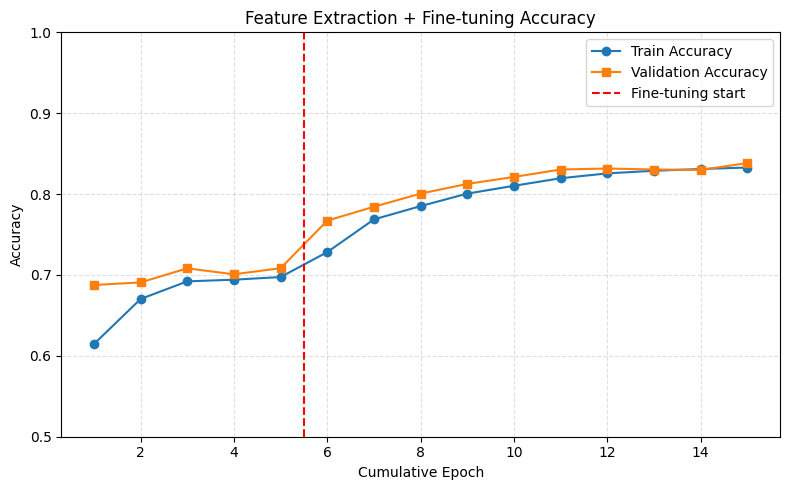

Feature extraction epochs: 1-5
Fine-tuning epochs: 6-15


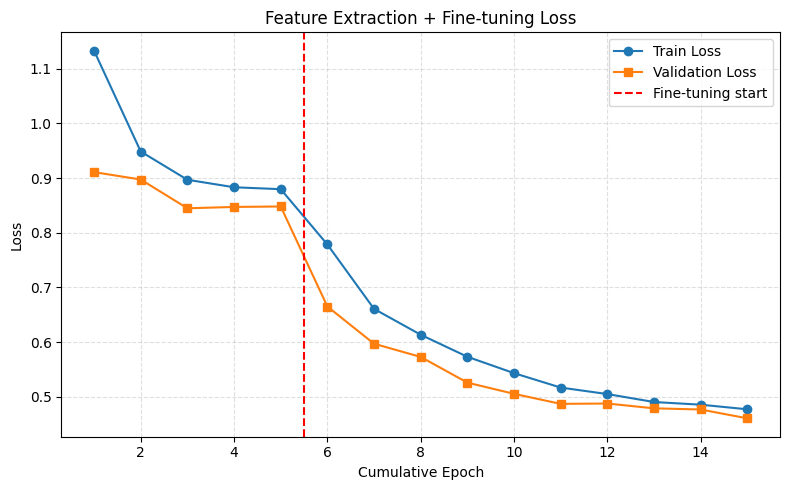

In [12]:
def combine_histories(initial: dict[str, list[float]], continued: dict[str, list[float]]):
    """Concatenate metric histories from feature extraction and fine-tuning runs."""
    if not initial or not continued:
        raise ValueError("Both initial and continued histories must be provided.")

    combined = {metric: list(initial.get(metric, [])) + list(continued.get(metric, []))
                for metric in set(initial) | set(continued)}

    initial_epochs = len(initial.get("train_acc", []))
    continued_epochs = len(continued.get("train_acc", []))
    epoch_index = np.arange(1, initial_epochs + continued_epochs + 1)

    boundary_epoch = initial_epochs
    return combined, epoch_index, boundary_epoch


def plot_combined_accuracy(initial_history: dict[str, list[float]],
                            continued_history: dict[str, list[float]]):
    combined, epoch_index, boundary = combine_histories(initial_history, continued_history)
    epoch_index = epoch_index[:15]

    plt.figure(figsize=(8, 5))
    plt.plot(epoch_index, combined["train_acc"][:15], label="Train Accuracy", marker="o")
    plt.plot(epoch_index, combined["val_acc"][:15], label="Validation Accuracy", marker="s")
    plt.axvline(boundary + 0.5, color="red", linestyle="--", linewidth=1.5, label="Fine-tuning start")
    plt.xlabel("Cumulative Epoch")
    plt.ylabel("Accuracy")
    plt.title("Feature Extraction + Fine-tuning Accuracy")
    plt.ylim(0.50, 1.0)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Feature extraction epochs: 1-{boundary}")
    print(f"Fine-tuning epochs: {boundary + 1}-{len(epoch_index)}")


def plot_combined_loss(initial_history: dict[str, list[float]],
                       continued_history: dict[str, list[float]]):
    combined, epoch_index, boundary = combine_histories(initial_history, continued_history)
    combined = combined
    epoch_index = epoch_index[:15]
    
    plt.figure(figsize=(8, 5))
    plt.plot(epoch_index, combined["train_loss"][:15], label="Train Loss", marker="o")
    plt.plot(epoch_index, combined["val_loss"][:15], label="Validation Loss", marker="s")
    plt.axvline(boundary + 0.5, color="red", linestyle="--", linewidth=1.5, label="Fine-tuning start")
    plt.xlabel("Cumulative Epoch")
    plt.ylabel("Loss")
    plt.title("Feature Extraction + Fine-tuning Loss")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


combined_history, combined_epochs, boundary_epoch = combine_histories(training_history, finetune_history)
print(f"Combined epochs: {len(combined_epochs)} (feature extraction: {boundary_epoch}, fine-tuning: {len(combined_epochs) - boundary_epoch})")
plot_combined_accuracy(training_history, finetune_history)
plot_combined_loss(training_history, finetune_history)